In [11]:
import pickle
import pandas as pd
from google.cloud import bigquery
from google.cloud import storage
import random

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from params import *
from utilities import *

import warnings
warnings.filterwarnings('ignore')

## Parametros

In [2]:
client_storage = storage.Client()
client_storage

## Carga de datos entrenamiento

In [3]:
data_original = bring_data_from_bq(table = tables[0], client_bq = client_bq, save = True, read_local = True)
data = prepare_data(data_original)

data.head(5)

Leyendo datos de la tabla: diabetes


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
0,0.0,64.0,0.0,11001.0,0.0,0.0,57.6,1.5,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,2.0,0.0
1,0.0,54.0,0.0,54001.0,1.0,0.0,57.6,1.5,25.6,57.0,30.00,374.00,0.0,0.0,0.0,0.0,75.0,2.0,0.0
2,0.0,69.0,0.0,15001.0,2.0,0.0,57.6,1.5,25.6,66.0,171.00,91.00,0.0,0.0,0.0,0.0,89.0,1.0,0.0
3,0.0,57.0,0.0,8001.0,3.0,0.0,57.6,1.5,25.6,39.0,143.00,280.00,0.0,0.0,0.0,0.0,95.0,2.0,1.0
4,0.0,50.0,0.0,19001.0,4.0,0.0,57.6,1.5,25.6,59.0,140.00,186.00,0.0,0.0,0.0,0.0,87.0,2.0,0.0


## Ajustes Modelo

In [5]:
# Conjunto de variables a usar en el entrenamiento

variables_to_train = ['edad',
                      'genero',
                      'codigo_ciudad_sucursal',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente',
                      'raza_paciente',
                      'diabetes']

In [13]:
## Consolidacion de los datos de entrenamiento

# Parametro para samplear o no los datos de entrenamiento
sample = True

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = data[data.diabetes == 1]
    sample = data[data.diabetes == 0].sample(len(df))
    df = pd.concat([df,sample]).dropna()
else:
    df = data

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train].copy()
df_to_train.head(5)

,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente,diabetes
3,57.0,0.0,8001.0,25.600000,39.00,143.0,280.0,0.0,0.0,0.0,0.0,95.0,2.0,3.0,0.0,1.0
11,43.0,0.0,50001.0,35.785147,44.92,121.0,321.0,0.0,0.0,0.0,1.0,126.0,3.0,0.0,0.0,1.0
21,32.0,0.0,11001.0,18.961927,81.00,83.0,34.0,0.0,0.0,0.0,1.0,74.0,2.0,3.0,0.0,1.0
26,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,3.0,4.0,0.0,1.0
31,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,1.0,4.0,0.0,1.0


In [14]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train[:-1]]
y = df_to_train[variables_to_train[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'auto', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente
3,57.0,0.0,8001.0,25.600000,39.00,143.0,280.0,0.0,0.0,0.0,0.0,95.0,2.0,3.0,0.0
11,43.0,0.0,50001.0,35.785147,44.92,121.0,321.0,0.0,0.0,0.0,1.0,126.0,3.0,0.0,0.0
21,32.0,0.0,11001.0,18.961927,81.00,83.0,34.0,0.0,0.0,0.0,1.0,74.0,2.0,3.0,0.0
26,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,3.0,4.0,0.0
31,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,1.0,4.0,0.0


RandomForestClassifier(max_depth=20, max_features='auto', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=200)

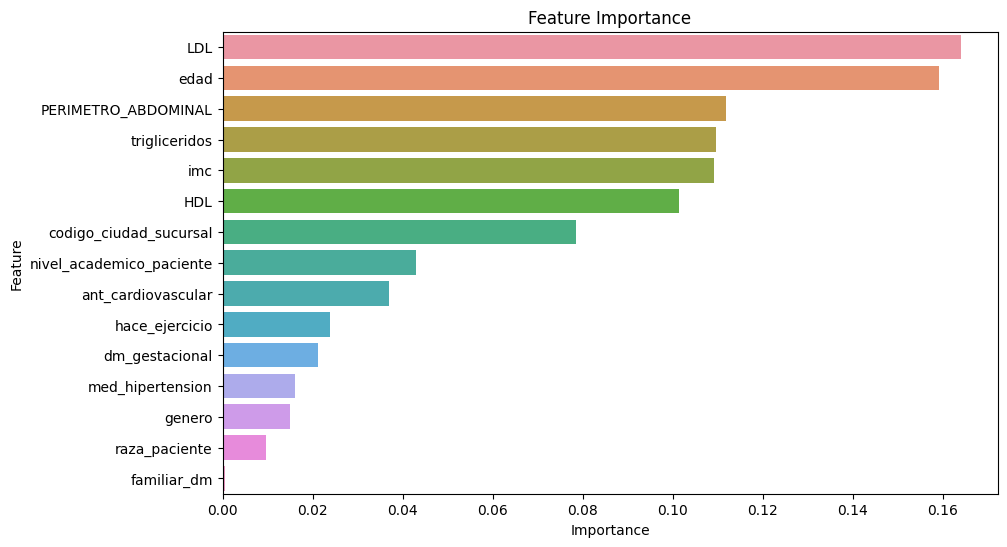

In [15]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [22]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = f1_score(y_test, y_pred)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 69.82
Modelo entrenado con f1 de: 0.7100011554396448
La matriz de confusion es:


,Negativo,Positivo
Negativo,19141,10068
Positivo,7501,21507


In [9]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 42.4%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
26500,0.0,59.0,0.0,11001.0,0.0,0.0,66.0,1.5,29.333333,42.0,109.0,109.0,0.0,0.0,0.0,0.0,95.0,2.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 45.96%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
287759,0.0,55.0,0.0,47001.0,5.0,0.0,80.9,1.57,32.820804,60.0,162.0,94.0,0.0,0.0,1.0,0.0,102.0,2.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 27.09%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
110144,0.0,58.0,1.0,52001.0,0.0,1.0,80.0,1.56,32.87311,43.0,168.0,157.0,1.0,0.0,1.0,0.0,98.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 55.71%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
79149,0.0,49.0,1.0,8001.0,4.0,0.0,129.6,1.8,40.0,42.1,132.1,102.0,1.0,0.0,1.0,0.0,134.0,2.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 42.67%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
186602,0.0,73.0,0.0,47001.0,3.0,0.0,48.0,1.6,18.75,54.5,105.8,90.1,1.0,0.0,1.0,0.0,60.0,3.0,1.0
